In [1]:
! pip install finta

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import hvplot.pandas
import seaborn as sns

import yfinance as yahooFinance
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from finta import TA

from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# import quantstats as qs

import warnings
warnings.filterwarnings("ignore")


C:\Users\Asia\anaconda3\envs\dev\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
end_date= "2024-03-01"
start_date="2012-03-01"
ticker= "TGT" # Enter the desired Ticker
# data is extracted from yahoofinance
ticker_df = yahooFinance.download(ticker, start=start_date, end=end_date, period='1d')
display(ticker_df.head())
display(ticker_df.tail())

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,40.712318,8223000
2012-03-02,56.590000,56.900002,56.360001,56.590000,40.590382,3462100
2012-03-05,56.709999,56.860001,56.119999,56.700001,40.669289,4053900
2012-03-06,56.240002,56.689999,56.119999,56.490002,40.518665,6344500
2012-03-07,56.529999,56.680000,56.259998,56.639999,40.626255,4776600


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-23,150.979996,152.779999,150.410004,151.479996,151.479996,3503600
2024-02-26,150.610001,150.949997,149.100006,150.149994,150.149994,3856900
2024-02-27,150.789993,152.309998,150.449997,151.990005,151.990005,2851700
2024-02-28,151.330002,152.250000,150.649994,151.440002,151.440002,2298300
2024-02-29,152.389999,153.649994,152.000000,152.919998,152.919998,4447800


In [4]:
ticker_df.shape

(3019, 6)

In [5]:
# dropped the Adj Close and converted column names to lower case, 
# so dataframe is aligned with 'finta' i.e. OHLCV

ticker_df=ticker_df.drop("Adj Close",axis=1)
column=["open","high","low","close","volume"]
ticker_df.columns=column

In [6]:
# to determine the average trend on short, medium and long basis
# iterating through list to generate "moving average" for all defined windows
sma_window=[7,20,30,50,100,200]
for i in sma_window:
    ticker_df[f"sma_{i}"]=ticker_df["close"].rolling(window=i).mean()

    
std_window=[7,20,30,50,100,200]
for i in std_window:
    ticker_df[f"{i}_day_std"]=ticker_df["close"].rolling(window=i).std()
    
for i in sma_window:
    ticker_df[f"{i}_DEMA"]=TA.DEMA(ticker_df, i)
    
ticker_df[["MACD","MACD_Signal"]]=TA.MACD(ticker_df)
ticker_df["RSA"]=TA.RSI(ticker_df,14)
ticker_df["STOCH"]=TA.STOCHRSI(ticker_df,14)
ticker_df["RSI"]=TA.RSI(ticker_df,14)



In [7]:
# calculate next day closing price to set as target in the models
window= 1
ticker_df[f"close_{window}days"]=ticker_df["close"].shift(-window)

In [8]:
# calculate downward pressure on index
ticker_df["high_close"]=ticker_df["high"]-ticker_df["close"]
# calculate upward pressure on index
ticker_df["open-low"]=ticker_df["open"]-ticker_df["low"]
ticker_df

,open,high,low,close,volume,sma_7,sma_20,sma_30,sma_50,sma_100,...,100_DEMA,200_DEMA,MACD,MACD_Signal,RSA,STOCH,RSI,close_1days,high_close,open-low
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,8223000,NaN,NaN,NaN,NaN,NaN,...,56.759998,56.759998,0.000000,0.000000,NaN,NaN,NaN,56.590000,0.150002,0.389999
2012-03-02,56.590000,56.900002,56.360001,56.590000,3462100,NaN,NaN,NaN,NaN,NaN,...,56.631654,56.632076,-0.003814,-0.002119,0.000000,NaN,0.000000,56.700001,0.310001,0.230000
2012-03-05,56.709999,56.860001,56.119999,56.700001,4053900,NaN,NaN,NaN,NaN,NaN,...,56.660695,56.660623,-0.001449,-0.001844,41.067062,NaN,41.067062,56.490002,0.160000,0.590000
2012-03-06,56.240002,56.689999,56.119999,56.490002,6344500,NaN,NaN,NaN,NaN,NaN,...,56.579840,56.580752,-0.007919,-0.003902,22.266928,NaN,22.266928,56.639999,0.199997,0.120003
2012-03-07,56.529999,56.680000,56.259998,56.639999,4776600,NaN,NaN,NaN,NaN,NaN,...,56.593470,56.593794,-0.005300,-0.004318,42.511210,NaN,42.511210,57.230000,0.040001,0.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,150.979996,152.779999,150.410004,151.479996,3503600,148.781427,145.897999,143.962000,142.538199,130.0171,...,141.310790,129.034883,2.595179,2.259615,64.405685,0.673349,64.405685,150.149994,1.300003,0.569992
2024-02-26,150.610001,150.949997,149.100006,150.149994,3856900,149.512854,146.278999,144.232999,142.827999,130.4517,...,141.750961,129.372358,2.570690,2.321830,60.654395,0.678406,60.654395,151.990005,0.800003,1.509995
2024-02-27,150.789993,152.309998,150.449997,151.990005,2851700,150.321426,146.802499,144.602333,143.100199,130.9000,...,142.249316,129.741641,2.668989,2.391262,63.796096,0.682839,63.796096,151.440002,0.319992,0.339996


In [9]:
# generated columns for the past days using shift()
lagging= [30,45,60,90,120,150,200]
for lag in lagging:
    ticker_df[f"lag_{lag}"]=ticker_df["close"].shift((lag))

In [10]:
# calculating volume change
ticker_df["vol_change"]=ticker_df["volume"].pct_change()

In [11]:
ticker_df.head(61)

,open,high,low,close,volume,sma_7,sma_20,sma_30,sma_50,sma_100,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,56.590000,56.910000,56.200001,56.759998,8223000,NaN,NaN,NaN,NaN,NaN,...,0.150002,0.389999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-02,56.590000,56.900002,56.360001,56.590000,3462100,NaN,NaN,NaN,NaN,NaN,...,0.310001,0.230000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.578974
2012-03-05,56.709999,56.860001,56.119999,56.700001,4053900,NaN,NaN,NaN,NaN,NaN,...,0.160000,0.590000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170937
2012-03-06,56.240002,56.689999,56.119999,56.490002,6344500,NaN,NaN,NaN,NaN,NaN,...,0.199997,0.120003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.565036
2012-03-07,56.529999,56.680000,56.259998,56.639999,4776600,NaN,NaN,NaN,NaN,NaN,...,0.040001,0.270000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.247127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-21,55.430000,55.900002,54.930000,55.830002,4779400,55.264286,56.2095,56.541000,57.1842,NaN,...,0.070000,0.500000,57.520000,58.410000,NaN,NaN,NaN,NaN,NaN,-0.331019
2012-05-22,55.889999,56.900002,55.810001,56.669998,5777400,55.441429,56.2065,56.550000,57.1580,NaN,...,0.230003,0.079998,56.400002,58.369999,NaN,NaN,NaN,NaN,NaN,0.208813
2012-05-23,56.240002,56.889999,55.939999,56.779999,3956300,55.707143,56.2040,56.536000,57.1240,NaN,...,0.110001,0.300003,57.200001,58.009998,NaN,NaN,NaN,NaN,NaN,-0.315211


In [12]:
ticker_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'sma_7', 'sma_20', 'sma_30',
       'sma_50', 'sma_100', 'sma_200', '7_day_std', '20_day_std', '30_day_std',
       '50_day_std', '100_day_std', '200_day_std', '7_DEMA', '20_DEMA',
       '30_DEMA', '50_DEMA', '100_DEMA', '200_DEMA', 'MACD', 'MACD_Signal',
       'RSA', 'STOCH', 'RSI', 'close_1days', 'high_close', 'open-low',
       'lag_30', 'lag_45', 'lag_60', 'lag_90', 'lag_120', 'lag_150', 'lag_200',
       'vol_change'],
      dtype='object')

In [13]:
ticker_df=ticker_df.drop(columns=['open', 'high', 'low'])

In [14]:
ticker_df.columns

Index(['close', 'volume', 'sma_7', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', '7_day_std', '20_day_std', '30_day_std', '50_day_std',
       '100_day_std', '200_day_std', '7_DEMA', '20_DEMA', '30_DEMA', '50_DEMA',
       '100_DEMA', '200_DEMA', 'MACD', 'MACD_Signal', 'RSA', 'STOCH', 'RSI',
       'close_1days', 'high_close', 'open-low', 'lag_30', 'lag_45', 'lag_60',
       'lag_90', 'lag_120', 'lag_150', 'lag_200', 'vol_change'],
      dtype='object')

In [15]:
ticker_df.shape

(3019, 36)

In [16]:
ticker_df=ticker_df.dropna()
ticker_df.isnull().sum()

close          0
volume         0
sma_7          0
sma_20         0
sma_30         0
sma_50         0
sma_100        0
sma_200        0
7_day_std      0
20_day_std     0
30_day_std     0
50_day_std     0
100_day_std    0
200_day_std    0
7_DEMA         0
20_DEMA        0
30_DEMA        0
50_DEMA        0
100_DEMA       0
200_DEMA       0
MACD           0
MACD_Signal    0
RSA            0
STOCH          0
RSI            0
close_1days    0
high_close     0
open-low       0
lag_30         0
lag_45         0
lag_60         0
lag_90         0
lag_120        0
lag_150        0
lag_200        0
vol_change     0
dtype: int64

In [17]:
# displaying Closing Price for ticker using hv plot
ticker_df['close'].hvplot(xlabel = 'Date', ylabel = 'Close Price'
                          , title = f'{ticker} Close Price',width=800,height=400).opts(yformatter='$%.0f')

:Curve   [Date]   (close)

In [18]:
# setting feature columns and target variable
X = ticker_df.drop(["close_1days","close","volume"], axis='columns')
y = ticker_df['close_1days']

In [19]:
from pandas.tseries.offsets import DateOffset
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 110 months
training_end = X.index.min() + DateOffset(months =118)


# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

2012-12-17 00:00:00


,sma_7,sma_20,sma_30,sma_50,sma_100,sma_200,7_day_std,20_day_std,30_day_std,50_day_std,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-17,151.880001,153.0965,158.039333,161.5692,157.1144,187.31415,3.266328,3.732911,8.060034,8.397849,...,1.750000,1.060013,164.600006,172.479996,157.740005,156.699997,236.500000,208.759995,231.910004,-0.332871
2022-10-18,152.578572,152.9565,157.827666,161.3744,157.1225,186.94310,3.851584,3.504720,7.992610,8.382966,...,3.900009,0.520004,163.580002,173.389999,157.490005,154.550003,230.970001,215.350006,231.440002,0.750928
2022-10-19,152.905714,152.7745,157.314333,161.1798,157.0444,186.56030,3.997735,3.258594,7.617103,8.407143,...,2.800003,3.059998,170.789993,180.190002,151.809998,149.669998,236.389999,215.589996,231.949997,-0.530593
2022-10-20,152.891427,152.8465,156.731000,160.8744,156.9170,186.16145,3.991261,3.278754,7.115139,8.369699,...,4.760010,2.559998,171.899994,175.339996,154.600006,144.809998,228.649994,220.630005,234.169998,0.179322
2022-10-21,153.609998,153.1755,156.249000,160.6662,156.8901,185.81310,4.655272,3.570889,6.381427,8.277181,...,0.069992,0.239990,173.649994,173.050003,159.419998,142.699997,229.779999,226.050003,228.860001,0.139132


,sma_7,sma_20,sma_30,sma_50,sma_100,sma_200,7_day_std,20_day_std,30_day_std,50_day_std,...,high_close,open-low,lag_30,lag_45,lag_60,lag_90,lag_120,lag_150,lag_200,vol_change
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-22,148.014284,145.432999,143.715666,142.243799,129.6080,130.90415,2.138705,3.301199,3.802710,3.729063,...,0.639999,0.799988,143.770004,138.369995,131.460007,110.800003,126.949997,132.699997,156.300003,0.085023
2024-02-23,148.781427,145.897999,143.962000,142.538199,130.0171,130.87905,2.298900,3.469567,4.058544,3.865840,...,1.300003,0.569992,144.089996,137.720001,131.330002,111.980003,126.550003,134.639999,156.500000,0.399313
2024-02-26,149.512854,146.278999,144.232999,142.827999,130.4517,130.84270,1.620931,3.498517,4.193585,3.882777,...,0.800003,1.509995,142.020004,139.580002,131.669998,111.389999,125.519997,134.080002,157.419998,0.100839
2024-02-27,150.321426,146.802499,144.602333,143.100199,130.9000,130.81400,1.094967,3.532104,4.374830,4.038526,...,0.319992,0.339996,140.910004,136.899994,131.320007,112.559998,125.190002,135.410004,157.729996,-0.260624
2024-02-28,150.582855,147.348499,144.947999,143.306199,131.3482,130.77685,1.115077,3.349107,4.494160,4.196119,...,0.809998,0.680008,141.070007,139.369995,133.809998,110.209999,123.709999,133.600006,158.869995,-0.194060


In [20]:
# Create StandardScaler instance for scaling of data
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Model Implementation

In [21]:
# In GridSearch function used Sklearn 'GridSearchCV' to estimate the best models parameters   
def gridsearch(model,param_grid):
    # intitiating gridsearch
    gs_csv=GridSearchCV(estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1)
     # fitting on the desired model       
    gs_csv.fit(X_train_scaled,y_train)
    # generating and returning diff. scores
    best_model=gs_csv.best_estimator_
    best_params=gs_csv.best_params_
    best_score=gs_csv.best_score_
    
    return best_model,best_params,best_score
            

In [22]:
# Making Prediction for testing data
def predict(best_model,X_test_scaled):
    
    r2=0
    mae=0
    mse=0
    rmse=0
    
    predictions=best_model.predict(X_test_scaled)
    
    mae=round((metrics.mean_absolute_error(y_test, predictions)),4)
    mse=round((metrics.mean_squared_error(y_test, predictions)),4)
    rmse=round((np.sqrt(metrics.mean_squared_error(y_test, predictions))),4)
    r2= round((metrics.r2_score(y_test, predictions)),4)
    
    print('Mean Absolute Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R2 Score:', r2)
    
    # DF is created for hv plot visualization 
    predictions_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test})
    display(predictions_df.hvplot(xlabel = 'Date', ylabel = 'Close Price', title = f'{ticker} Close Price',width=1000,height=400).opts(yformatter='$%.0f'))
    
    return mae,mse,rmse,r2,predictions
  

In [23]:
# This function is using feature importance of models to display the weightage of features used by model
def feature_imp(best_model):
    importances = best_model.feature_importances_
    # sorted_index = np.argsort(importances)[::-1]
    # x_values = range(len(importances))
    # labels = X.columns.values.tolist()
    importance_data = list(zip(X.columns, best_model.feature_importances_))
    importances_df = pd.DataFrame(importance_data, columns =['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False).set_index('Feature')
    display(importances_df.hvplot.bar(xlabel = 'Date', ylabel = 'Feature Importance', title = 'Models Feature Importance',height=400).opts(xrotation=90))
    
    return importances, importance_data,importances_df


## RandomForestRegressor

In [24]:
# intitiating RandomForestRegressor
rf= RandomForestRegressor()

In [25]:
# defined parameters
# these parameters were generated through running diffrent paramaters

param_grid_rf={"n_estimators": [100],
            "max_depth": [6],
            "max_features" :[ 5]
           }

In [26]:
# called the gridsearch function,defined above, for fitting the best model
gs_csv_rf=gridsearch(rf,param_grid_rf)
rf_best=gs_csv_rf[0]
print(gs_csv_rf)

# Displaying
#best estimator for the model, 
# best parameters
# best score for model based upon the estimator and parameters
       

Fitting 5 folds for each of 1 candidates, totalling 5 fits
(RandomForestRegressor(max_depth=6, max_features=5), {'max_depth': 6, 'max_features': 5, 'n_estimators': 100}, -724.2611587383128)


In [27]:
# predictions of X_test data
prediction=predict(rf_best,X_test_scaled)
rf_r2= prediction[3]
rf_mse=prediction[1]
chart_rf= prediction[4]

Mean Absolute Error: 7.9523
Mean Squared Error: 96.4992
Root Mean Squared Error: 9.8234
R2 Score: 0.7219


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [28]:
# Displaying important features generated from above model
# Features have been extracted and generated through function defined as 'feature_imp'
features= feature_imp(rf_best)

:Bars   [Feature]   (Importance)

## XGBoost Regressor

In [29]:
# initiating XGBRegressor
xgb_model= xgb.XGBRegressor()


In [30]:
# defined parameters
# these parameters were generated through running diffrent paramaters
param_grid_xgb= {"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [3],
                        "min_child_weight": [4],
                        'subsample': [0.7],
                        "n_estimators": [500]}
           

In [31]:
#called the gridsearch function,defined above, for fitting the best model
gs_csv_xgb=gridsearch(xgb_model,param_grid_xgb)
xgb_best=gs_csv_xgb[0]
display(gs_csv_xgb)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 {'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 4,
  'n_estimators': 500,
  'subsample': 0.7},
 -690.8051732459639)

In [32]:
# predictions made for X_test data through predict function

prediction_xgb=predict(xgb_best,X_test_scaled)
# print('Mean Absolute Error:', prediction_xgb[0])
# print('Mean Squared Error:', prediction_xgb[1])
# print('Root Mean Squared Error:', prediction_xgb[2])
# print('R2 Score:', prediction_xgb[3])
xgb_r2= prediction_xgb[3]
xgb_mse=prediction_xgb[1]
chart_xgb=prediction_xgb[4]

Mean Absolute Error: 3.1949
Mean Squared Error: 18.7007
Root Mean Squared Error: 4.3244
R2 Score: 0.9461


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [33]:
# extracting and Displaying important features
features_xgb= feature_imp(xgb_best)

:Bars   [Feature]   (Importance)

## GradientBoost Regression

In [34]:
# initiating model
gb_model= GradientBoostingRegressor()

# defined paarmeters 
param_grid_gb= {'alpha':[0.05],
                        "max_depth": [3],
                        "learning_rate": [0.15],
                        'subsample': [0.7],
                        "n_estimators": [500]}


# {'alpha':[0.05,0.1,0.3,1,3,5,10],
#                         "max_depth": [3],
#                         "learning_rate": (0.05, 0.10, 0.15),
#                         'subsample': [0.7],
#                         "n_estimators": [500]}
           

In [35]:
#called the gridsearch function,defined above, for fitting the best model

gs_csv_gb=gridsearch(gb_model,param_grid_gb)
gb_best=gs_csv_gb[0]
display(gs_csv_gb)
                    

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(GradientBoostingRegressor(alpha=0.05, learning_rate=0.15, n_estimators=500,
                           subsample=0.7),
 {'alpha': 0.05,
  'learning_rate': 0.15,
  'max_depth': 3,
  'n_estimators': 500,
  'subsample': 0.7},
 -667.9583043808848)

In [36]:
# predictions made on X_test data

prediction_gb=predict(gb_best,X_test_scaled)
gb_r2= prediction_gb[3]
gb_mse=prediction_gb[1]
chart_gb=prediction_gb[4]

Mean Absolute Error: 6.623
Mean Squared Error: 69.8876
Root Mean Squared Error: 8.3599
R2 Score: 0.7986


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [37]:
# Displaying important features
features_gb= feature_imp(gb_best)

:Bars   [Feature]   (Importance)

## LinearRegression

In [38]:
#initiating Linear Regression

lr_model= LinearRegression()


In [39]:
# defining model parameters
param_grid_lrm= {'fit_intercept': [True, False], 'positive': [True, False]}
           

In [40]:
# called the gridsearch function,defined above, for fitting the best model

gs_csv_lr=gridsearch(lr_model,param_grid_lrm)
lr_best=gs_csv_lr[0]
display(gs_csv_lr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


(LinearRegression(),
 {'fit_intercept': True, 'positive': False},
 -6.486129274602052)

In [41]:
# prediction of X_test data
prediction_lr=predict(lr_best,X_test_scaled)

lr_r2= prediction_lr[3]
lr_mse=prediction_lr[1]
chart_lr=prediction_lr[4]

Mean Absolute Error: 2.3283
Mean Squared Error: 11.5309
Root Mean Squared Error: 3.3957
R2 Score: 0.9668


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## Ridge

In [42]:
# initiating Ridge
ridge_model= Ridge()
param_grid_ridge= {'alpha':[0.05,0.1,0.3,1,3,5,10]}
                   

In [43]:
# defined model parameters
gs_csv_ridge=GridSearchCV(estimator=ridge_model,
                    param_grid=param_grid_ridge,
                    scoring='neg_mean_squared_error',
                    cv=5,
                    verbose=True)

In [44]:
# called the gridsearch function,defined above, for fitting the best model
gs_csv_ridge=gridsearch(ridge_model,param_grid_ridge)
ridge_best=gs_csv_ridge[0]
display(gs_csv_ridge)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


(Ridge(alpha=0.05), {'alpha': 0.05}, -7.702243203300671)

In [45]:

# testing X_test data
prediction_ridge=predict(ridge_best,X_test_scaled)

ridge_r2= prediction_ridge[3]
ridge_mse=prediction_ridge[1]
chart_ridge=prediction_ridge[4]

Mean Absolute Error: 2.3871
Mean Squared Error: 11.7103
Root Mean Squared Error: 3.422
R2 Score: 0.9663


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## Stacking the Models

In [46]:
## fitting the Regressor for stacking models
def stacked_fit(stacking_model,stacking_estimator,f_estimator):
    
    if stacking_model==StackingRegressor:
        # initiating Stacking Regressor
        regressor=stacking_model(stacking_estimator,f_estimator,n_jobs=5, verbose=False)
    else:
        regressor=stacking_model(stacking_estimator,n_jobs=5, verbose=False)
        
    # fitting the regressor
    regressor.fit(X_train_scaled,y_train)
    return regressor

# predictions for stacking models

def stacked_predict(pred_regressor,x_testing_data,y_testing_data):
    
    pred_r2=0
    pred_mae=0
    pred_mse=0
    pred_rmse=0
    chart=""

    
    predictions_regressor=pred_regressor.predict(x_testing_data)
    pred_r2= metrics.r2_score(y_testing_data, predictions_regressor)
    pred_mae=metrics.mean_absolute_error(y_testing_data,predictions_regressor)
    pred_mse=metrics.mean_squared_error(y_testing_data, predictions_regressor)
    pred_rmse=np.sqrt(metrics.mean_squared_error(y_testing_data, predictions_regressor))
    
    print('Mean Absolute Error:', pred_mae)
    print('Mean Squared Error:', pred_mse)
    print('Root Mean Squared Error:', pred_rmse)
    print('R2 Score:', pred_r2)
    
    predictions_df=pd.DataFrame({"Prediction": predictions_regressor, "Actual": y_testing_data})  
    display(predictions_df.hvplot(xlabel = 'Date', ylabel = 'Close Price', title = f'{ticker} Close Price',width=800,height=400).opts(yformatter='$%.0f'))
    return pred_mae,pred_mse,pred_rmse,pred_r2,predictions_regressor
    
            

In [47]:
# defining list of estimating models for stacking models
stacking_estimator= [('rfr', rf),
            ('lr',lr_model),
            ('xgb',xgb_model),
            ('gb',gb_model),
            ('ridge', ridge_model)
           ]

final_estimator=rf

# defining the stacking model
stacking_model=StackingRegressor       

In [48]:
# calling & fitting regressor
stacking_regressor=stacked_fit(stacking_model,stacking_estimator,final_estimator)   

display(stacking_regressor)


StackingRegressor(estimators=[('rfr', RandomForestRegressor()),
                              ('lr', LinearRegression()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            imp...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('gb', GradientBoostingRegressor()),
                              ('ridge', Ridge())],
                  final_estimator=RandomForestRegressor(), n_jobs=5,
                  verbose=False)

In [49]:
# Training Data predictions
prediction_stacked_tr=stacked_predict(stacking_regressor,X_train_scaled,y_train)

stacked_r2_train= round((prediction_stacked_tr[3]),4)
stacked_mse_train=round((prediction_stacked_tr[1]),4)

Mean Absolute Error: 1.4343732692736995
Mean Squared Error: 6.914625083227614
Root Mean Squared Error: 2.629567470750202
R2 Score: 0.9978477496387937


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [50]:
# # Testing Data Predictions
prediction_stacked_test=stacked_predict(stacking_regressor,X_test_scaled,y_test)
# print('Mean Absolute Error:', prediction_stacked_test[0])
# print('Mean Squared Error:', prediction_stacked_test[1])
# print('Root Mean Squared Error:', prediction_stacked_test[2])
# print('R2 Score:', prediction_stacked_test[3])
stacked_r2_test= round((prediction_stacked_test[3]),4)
stacked_mse_test=round((prediction_stacked_test[1]),4)
chart_stacked_reg= prediction_stacked_test[4]

Mean Absolute Error: 2.9834845791474716
Mean Squared Error: 15.346097157127002
Root Mean Squared Error: 3.9174094957161425
R2 Score: 0.9557770893667284


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## Voting Classifier

In [51]:
# defining voting Regressor and calling function to fir model on training data
vc_model=VotingRegressor
vc_regressor=stacked_fit(vc_model,stacking_estimator,0)
display(vc_regressor)


VotingRegressor(estimators=[('rfr', RandomForestRegressor()),
                            ('lr', LinearRegression()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          impor...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('gb', GradientBoostingRegressor()),
                            ('ridge', Ridge())],
                n_jobs=5)

In [52]:
# Training Data predictions
prediction_vc_tr=stacked_predict(vc_regressor,X_train_scaled,y_train)

vc_r2_training= round((prediction_vc_tr[3]),4)
vc_mse_training=round((prediction_vc_tr[1]),4)

Mean Absolute Error: 0.8572900467223358
Mean Squared Error: 2.1873163105320184
Root Mean Squared Error: 1.4789578460970476
R2 Score: 0.9993191746099389


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [53]:
# # Testing Data Predictions
prediction_vc_test=stacked_predict(vc_regressor,X_test_scaled,y_test)

vc_r2_testing= round((prediction_vc_test[3]),4)
vc_mse_testing=round((prediction_vc_test[1]),4)
chart_vc_reg= prediction_vc_test[4]

Mean Absolute Error: 3.202890977554859
Mean Squared Error: 17.4336740865376
Root Mean Squared Error: 4.175365144096693
R2 Score: 0.949761310433221


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

# Model Results

## Comparison of Training & Testing Results

In [54]:
# comparing r2 and Mean Squared Error for training & tesing data between Stacking Regressor and Voting Regressor
model_performance={"model":['Stacking_Model_Tr','Stacking_Model_Testing','VC_training','VC_testing'],
                   "r^2": [stacked_r2_train, stacked_r2_test,vc_r2_training,vc_r2_testing],
                   "MSE":[stacked_mse_train,stacked_mse_test,vc_mse_training,vc_mse_testing]}
model_performance_df=pd.DataFrame(model_performance)
# set index as model_name
model_performance_df=model_performance_df.set_index("model")
# display the results
model_performance_df

,r^2,MSE
model,,
Stacking_Model_Tr,0.9978,6.9146
Stacking_Model_Testing,0.9558,15.3461
VC_training,0.9993,2.1873
VC_testing,0.9498,17.4337


## Comparison of All Models


In [60]:
# Visulaization Stock Price Prediction for all implemented Models
# Step 1, Created a new dataframe
# step2, Added into fataframe above  generated predicted prices from all models. 

df_combined=pd.DataFrame({"Actual": y_test})
df_combined["Stacked"]= chart_stacked_reg
df_combined["Voting_cl"]=chart_vc_reg
df_combined["RF"]=chart_rf
df_combined["XGB"]=chart_xgb
df_combined["GB"]=chart_gb
df_combined["LR"]=chart_lr
df_combined["Ridge"]=chart_ridge
# df_combined.head(5)
display(df_combined.hvplot(xlabel = 'Date', ylabel = 'Close Price'
                           , title = f'{ticker} Close Price- All Models'
                           ,width=1000,height=500).opts(yformatter='$%.0f'))

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

,r2,mse
model,,
Random_Forest,0.7219,96.4992
Gradient_boost,0.7986,69.8876
XGradient_boost,0.9461,18.7007
Linear_Regression,0.9668,11.5309
Ridge,0.9663,11.7103
Stacking_Models,0.9558,15.3461
VotingClassifier,0.9498,17.4337


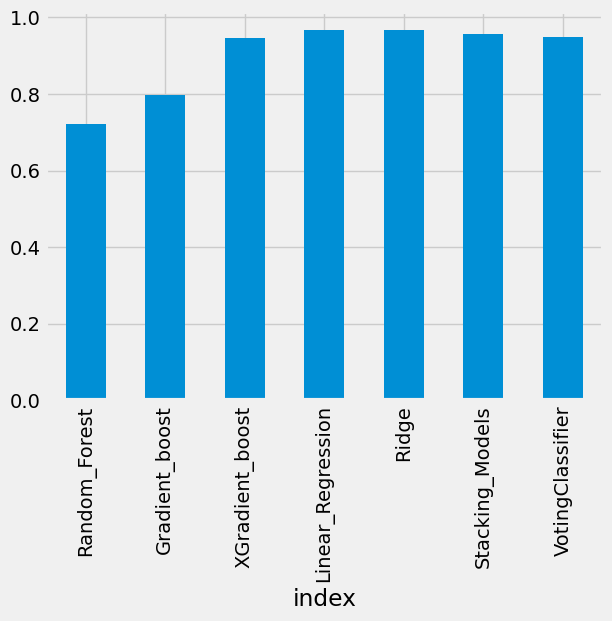

In [56]:

# created DF for r2 and Mean Squared Error of all models

# step 1 Created a dictionary
# step 2 converted created dictionary into dataframe
dict_results={"model":['Random_Forest','Gradient_boost','XGradient_boost','Linear_Regression','Ridge','Stacking_Models','VotingClassifier'], "r2":
              [rf_r2,gb_r2,xgb_r2,lr_r2,ridge_r2,stacked_r2_test,vc_r2_testing],"mse":
              [rf_mse,gb_mse,xgb_mse,lr_mse,ridge_mse,stacked_mse_test,vc_mse_testing]}
                                                                       
                                                           
result_df=pd.DataFrame(dict_results)
result_df=result_df.set_index("model")

# visulization through hv plot for r2
result_df["r2"].plot(kind="bar",xlabel="index")
result_df

<Axes: xlabel='index'>

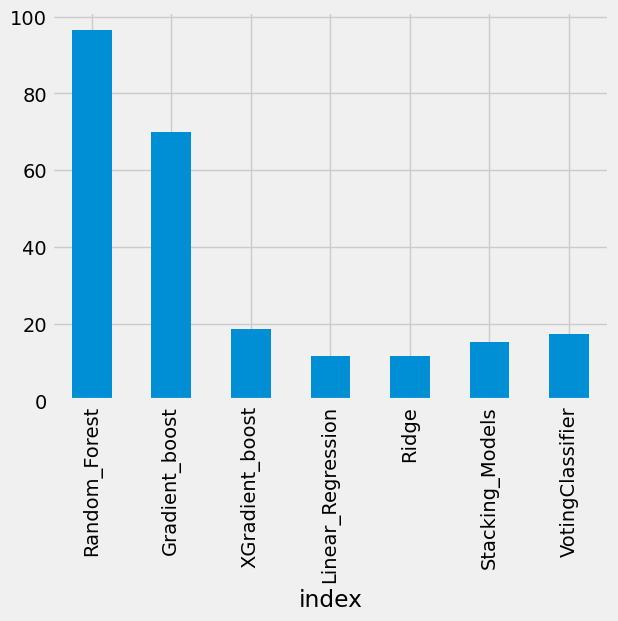

In [57]:
# visulization through hv plot for MSE
result_df["mse"].plot(kind="bar",xlabel="index")

In [58]:
# #create tearsheet

# stock = qs.utils.download_returns((f"{ticker}"))

# qs.reports.full(stock, (f"{ticker}"))